In [1]:
import pandas as pd
import numpy as np
import pyodbc 
from tqdm import tqdm

def collect_bp1(sql):
    conn = pyodbc.connect('DRIVER=/opt/examples/libtbodbc.so;SERVER=192.168.70.236;PORT=8629;SID=kotrabp;User=bpuser;Password=kotrabp;Database=kotrabp;',ansi=True,autocommit=True)    # BPUSER2 에서 데이터 가져옴  // 만약 BPUSER1에서 데이터를 가져올경우 'DSN=BP_DB2'로 변경
    conn.setdecoding(pyodbc.SQL_CHAR, encoding='cp949')
    conn.setdecoding(pyodbc.SQL_WCHAR, encoding='cp949')
    conn.setdecoding(pyodbc.SQL_WMETADATA, encoding='utf-32le')
    conn.setencoding(encoding='cp949')
    data= pd.read_sql_query(sql, conn)
    conn.close()
    return data


def collect_bp2(sql):
    conn = pyodbc.connect('DRIVER=/opt/examples/libtbodbc.so;SERVER=192.168.70.224;PORT=8629;SID=kotrabp;User=bpuser;Password=kotrabp;Database=kotrabp;',ansi=True,autocommit=True) 
    conn.setdecoding(pyodbc.SQL_CHAR, encoding='cp949')
    conn.setdecoding(pyodbc.SQL_WCHAR, encoding='cp949')
    conn.setdecoding(pyodbc.SQL_WMETADATA, encoding='utf-32le',)
    conn.setencoding(encoding='cp949')
    data= pd.read_sql_query(sql, conn)
    conn.close()
    return data





In [2]:
from fuzzywuzzy import fuzz
import Levenshtein as lev

In [3]:
!ls

check_duplicates-v2.ipynb  check_duplicates.ipynb  crm_r2_over.csv


In [4]:
# 데이터 읽기

df = pd.read_csv("crm_r2_over.csv", encoding = "cp949")

In [11]:
use_cols = ['해외기업등급', '국가', '입력무역관', '해외고객번호', '해외기업명(영문)']

In [12]:
# 분석 대상 데이터 컬럼만으로 데이터 재구성

df_ana = df[use_cols].copy()

In [13]:
df_ana.head()

,해외기업등급,국가,입력무역관,해외고객번호,해외기업명(영문)
0,R2,베트남,하노이무역관,CCMBY944881,\tAEON TOPVALU VIETNAM COMPANY LIMITED
1,R2,루마니아,부쿠레슈티무역관,CCMBY952255,\tALL RENTAL SRL
2,R3,베트남,호치민무역관,CCMBY950559,\tANPHACO TRADING COMPANY LIMITED
3,R2,중국,베이징무역관,CCMBY821489,\tBEIJING BEIQI PENGLONG AUTO SERVICE TRADING ...
4,R2,중국,베이징무역관,CCMBY692817,\tBEIJING GUANGHUA TIMES TEXTILE IMPORT&EXPORT...


In [14]:
def clean_text(text):
    return text.strip()

In [15]:
df_ana['clean_company'] = df_ana['해외기업명(영문)'].apply(clean_text)

In [16]:
df_ana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69773 entries, 0 to 69772
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   해외기업등급         69773 non-null  object
 1   국가             69610 non-null  object
 2   입력무역관          65893 non-null  object
 3   해외고객번호         69773 non-null  object
 4   해외기업명(영문)      69773 non-null  object
 5   clean_company  69773 non-null  object
dtypes: object(6)
memory usage: 3.2+ MB


In [17]:
## 두번째 해결과제 ##
# 중복이라고 판단되는 기업의 무엇을 옆에 기재할까??
# 기업 ID를 표시 # 상호 비교하며 전체 기업 ID를 기재??
# 해볼까??

In [19]:
df_ana['Duplicate_Company_Ids'] = None

In [20]:
df_ana['국가'].value_counts().head(30)

미국         5917
중국         5644
일본         5347
베트남        4032
인도         3228
아랍에미리트     2820
인도네시아      2190
독일         1901
싱가포르       1795
이탈리아       1736
태국         1601
튀르키예       1447
스페인        1294
러시아연방      1222
말레이시아      1169
프랑스        1160
사우디아라비아    1126
영국         1055
캐나다         946
필리핀         827
호주          808
이집트         740
멕시코         727
카자흐스탄       678
폴란드         675
홍콩          663
브라질         638
대만          572
콜롬비아        571
네덜란드        566
Name: 국가, dtype: int64

## 국가별/전체 기업 이름 사전 생성
---------------------------------------
+ 정확히 같은 이름을 가지는 기업들의 코드는 묶어 정리
+ ex) {기업 A : [ID_1, ID_2, ID_3]} 

In [21]:
def country_company_name_append(row):
     globals()[f'{country}_company_name'].setdefault(row['clean_company'], []).append(row['해외고객번호'])
        
def total_company_name_append(row):
    total_company_name.setdefault(row['clean_company'], []).append(row['해외고객번호'])

In [22]:
total_company_name={}
df_ana.apply(total_company_name_append, axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
69768    None
69769    None
69770    None
69771    None
69772    None
Length: 69773, dtype: object

### * 국가 이름을 결측치로 두면 이후 반복문 시 검색되지 않으므로 'Nan'으로 대체

In [23]:
df_ana['국가'].fillna('Nan', inplace=True)

In [24]:
country_list=df_ana['국가'].unique().tolist()
country_list.pop(country_list.index('Nan'))
country_list.append("Nan")

for country in country_list:
    globals()[f'{country}_df']=df_ana[df_ana['국가']==country]
    globals()[f'{country}_company_name']={}
    globals()[f'{country}_df'].apply(country_company_name_append, axis=1)

### 정확히 같은 한 기업명에 두 개 이상의 기업 ID 코드가 있는 경우

In [60]:
duplicate_keys=[key for key, value in 중국_company_name.items() if len(value)>=2]
for key in duplicate_keys[:10]:
    print(f'Duplicate Company name : {key} \n Duplicate Company ID : {중국_company_name[key]} \n')

Duplicate Company name : SHANGHAI FENGDAO TECHNOLOGICAL DEVELOPMENT CO., LTD. 
 Duplicate Company ID : ['CCMBY989922', 'CCM20230628040164'] 

Duplicate Company name : AD MARINE ENGINEERING 
 Duplicate Company ID : ['CCMBY416540', 'CCMBY045702'] 

Duplicate Company name : AIJIAMET WUHAN SUPPLY CHAIN MANAGEMENT CO LTD 
 Duplicate Company ID : ['CCMBY952756', 'CCMBY952752'] 

Duplicate Company name : ALE PAX 
 Duplicate Company ID : ['CCMBY957652', 'CCMBY954122'] 

Duplicate Company name : ANHUI QIUSHI MEDICAL TECHNOLOGY CO., LTD. 
 Duplicate Company ID : ['CCM20230802076351', 'CCM20230802076332'] 

Duplicate Company name : BEDOFU 
 Duplicate Company ID : ['CCMBY971003', 'CCMBY969449', 'CCMBY969281'] 

Duplicate Company name : BEIJING DAYADING MEDICAL APPLIANCE CO.,LTD 
 Duplicate Company ID : ['CCM20231220220729', 'CCM20231220220674'] 

Duplicate Company name : BEIJING HANJIE TECHNOLOGY CO., LTD 
 Duplicate Company ID : ['CCM20230628040236', 'CCMBY885213'] 

Duplicate Company name : BEIJ

In [26]:
len(중국_df['해외고객번호'])

5644

In [27]:
len(중국_company_name)

5498

In [28]:
len(duplicate_keys)

136

### 나라별로 묶어 중복 기업 확인
---------------------

1. 각 나라별 기업 이름 정리 (위 기업명 사전 참고)
2. 나라별로 데이터프레임 분리 (국가_df)
2. 국가_df 내의 기업명과 각 나라별 기업 이름 전체를 행별로 하나씩 비교
4. 만약 국가명이 Nan 인 경우, 원본 데이터에 있는 모든 기업명과 비교 (총 69773개)
5. 겹치는 국가명이나 코드가 없는 경우, 'None'으로 표시

* threshold는 90으로 설정
----------------------

개선 결과 약 6분 소요

In [48]:
def find_duplicates_in_country(row):
    current_row_company_name=row['clean_company']
    current_company_id=row['해외고객번호']
    duplicate_ids=[]
    if row['국가']=='Nan':
        country_company_name=total_company_name
    else:
        country_company_name=globals()[f'{country}_company_name']
    
    for company_name, company_ids in country_company_name.items():
        if fuzz.ratio(current_row_company_name, company_name) > 90:
            duplicate_ids+=company_ids
    if len(duplicate_ids)>=2:
        duplicate_ids.remove(current_company_id)
        row['Duplicate_Company_Ids']=duplicate_ids
    else:
        row['Duplicate_Company_Ids']='None'
    return row

In [50]:
for country in tqdm(country_list):
    print(f'{country} data duplicate matching....')
    globals()[f'{country}_df'].apply(find_duplicates_in_country, axis=1)

  0%|          | 0/202 [00:00<?, ?it/s]

베트남 data duplicate matching....


  0%|          | 1/202 [00:34<1:55:55, 34.60s/it]

루마니아 data duplicate matching....


  1%|          | 2/202 [00:35<48:21, 14.51s/it]  

중국 data duplicate matching....


  1%|▏         | 3/202 [01:42<2:08:58, 38.89s/it]

태국 data duplicate matching....


  2%|▏         | 5/202 [01:48<54:05, 16.47s/it]  

케냐 data duplicate matching....
우즈베키스탄 data duplicate matching....


  3%|▎         | 6/202 [01:48<35:53, 10.99s/it]

칠레 data duplicate matching....


  3%|▎         | 7/202 [01:49<24:32,  7.55s/it]

브라질 data duplicate matching....


  4%|▍         | 9/202 [01:50<12:10,  3.79s/it]

아르헨티나 data duplicate matching....
홍콩 data duplicate matching....


  5%|▍         | 10/202 [01:51<09:18,  2.91s/it]

이라크 data duplicate matching....


  5%|▌         | 11/202 [01:51<06:45,  2.12s/it]

요르단 data duplicate matching....


  7%|▋         | 15/202 [01:52<02:21,  1.32it/s]

모잠비크 data duplicate matching....
슬로베니아 data duplicate matching....
튀니지 data duplicate matching....
러시아연방 data duplicate matching....


  8%|▊         | 16/202 [01:55<03:55,  1.26s/it]

싱가포르 data duplicate matching....


  8%|▊         | 17/202 [02:02<07:55,  2.57s/it]

독일 data duplicate matching....


  9%|▉         | 18/202 [02:10<11:51,  3.87s/it]

튀르키예 data duplicate matching....


  9%|▉         | 19/202 [02:14<12:19,  4.04s/it]

일본 data duplicate matching....


 10%|▉         | 20/202 [03:12<56:51, 18.75s/it]

미국 data duplicate matching....


 10%|█         | 21/202 [04:23<1:40:48, 33.42s/it]

쿠웨이트 data duplicate matching....


 11%|█         | 22/202 [04:24<1:12:02, 24.02s/it]

카자흐스탄 data duplicate matching....


 11%|█▏        | 23/202 [04:25<51:42, 17.33s/it]  

이집트 data duplicate matching....


 12%|█▏        | 24/202 [04:26<37:22, 12.60s/it]

카타르 data duplicate matching....


 12%|█▏        | 25/202 [04:26<26:33,  9.00s/it]

사우디아라비아 data duplicate matching....


 13%|█▎        | 26/202 [04:29<20:56,  7.14s/it]

이탈리아 data duplicate matching....


 13%|█▎        | 27/202 [04:36<20:12,  6.93s/it]

콜롬비아 data duplicate matching....


 15%|█▍        | 30/202 [04:36<07:57,  2.77s/it]

아르메니아 data duplicate matching....
몽골 data duplicate matching....
인도 data duplicate matching....


 15%|█▌        | 31/202 [04:58<21:21,  7.50s/it]

프랑스 data duplicate matching....


 16%|█▌        | 32/202 [05:01<17:54,  6.32s/it]

스페인 data duplicate matching....


 16%|█▋        | 33/202 [05:05<15:42,  5.57s/it]

인도네시아 data duplicate matching....


 17%|█▋        | 34/202 [05:15<19:01,  6.79s/it]

방글라데시 data duplicate matching....


 18%|█▊        | 37/202 [05:15<07:35,  2.76s/it]

한국 data duplicate matching....
에콰도르 data duplicate matching....
말레이시아 data duplicate matching....


 19%|█▉        | 38/202 [05:18<07:36,  2.78s/it]

페루 data duplicate matching....


 19%|█▉        | 39/202 [05:19<05:53,  2.17s/it]

엘살바도르 data duplicate matching....
아랍에미리트 data duplicate matching....


 20%|██        | 41/202 [05:35<12:56,  4.82s/it]

스웨덴 data duplicate matching....
영국 data duplicate matching....


 22%|██▏       | 44/202 [05:38<07:18,  2.77s/it]

세르비아 data duplicate matching....
에티오피아 data duplicate matching....
체코 data duplicate matching....


 23%|██▎       | 46/202 [05:38<04:39,  1.79s/it]

아제르바이잔 data duplicate matching....
필리핀 data duplicate matching....


 24%|██▍       | 48/202 [05:40<03:41,  1.44s/it]

이스라엘 data duplicate matching....


 24%|██▍       | 49/202 [05:40<03:04,  1.21s/it]

그리스 data duplicate matching....


 25%|██▌       | 51/202 [05:41<02:05,  1.20it/s]

헝가리 data duplicate matching....
파나마 data duplicate matching....


 26%|██▌       | 52/202 [05:41<01:36,  1.55it/s]

볼리비아 data duplicate matching....
멕시코 data duplicate matching....


 27%|██▋       | 54/202 [05:42<01:36,  1.54it/s]

폴란드 data duplicate matching....


 27%|██▋       | 55/202 [05:43<01:46,  1.38it/s]

아일랜드 data duplicate matching....
슬로바키아 data duplicate matching....
호주 data duplicate matching....


 29%|██▊       | 58/202 [05:45<01:28,  1.64it/s]

마다가스카르 data duplicate matching....
캐나다 data duplicate matching....


 30%|██▉       | 60/202 [05:47<01:42,  1.39it/s]

남아프리카공화국 data duplicate matching....


 30%|███       | 61/202 [05:47<01:36,  1.46it/s]

가나 data duplicate matching....
뉴질랜드 data duplicate matching....
몰타 data duplicate matching....
알제리 data duplicate matching....


 34%|███▎      | 68/202 [05:48<00:32,  4.09it/s]

오스트리아 data duplicate matching....
포르투갈 data duplicate matching....
크로아티아 data duplicate matching....
대만 data duplicate matching....


 35%|███▍      | 70/202 [05:49<00:38,  3.42it/s]

불가리아 data duplicate matching....
핀란드 data duplicate matching....
네덜란드 data duplicate matching....


 36%|███▌      | 72/202 [05:49<00:42,  3.08it/s]

스위스 data duplicate matching....


 36%|███▌      | 73/202 [05:50<00:42,  3.07it/s]

레바논 data duplicate matching....
리투아니아 data duplicate matching....
오만 data duplicate matching....


 38%|███▊      | 76/202 [05:50<00:27,  4.50it/s]

예멘 data duplicate matching....
파키스탄 data duplicate matching....


 39%|███▊      | 78/202 [05:51<00:30,  4.04it/s]

나이지리아 data duplicate matching....
라오스 data duplicate matching....


 44%|████▎     | 88/202 [05:51<00:10, 10.51it/s]

모나코 data duplicate matching....
알바니아 data duplicate matching....
EU data duplicate matching....
조지아 data duplicate matching....
보츠와나 data duplicate matching....
스리랑카 data duplicate matching....
룩셈부르크 data duplicate matching....
미얀마 data duplicate matching....
바레인 data duplicate matching....


 45%|████▍     | 90/202 [05:51<00:10, 10.40it/s]

덴마크 data duplicate matching....
노르웨이 data duplicate matching....
이란 data duplicate matching....


 47%|████▋     | 94/202 [05:52<00:12,  8.86it/s]

모로코 data duplicate matching....
리비아 data duplicate matching....
과테말라 data duplicate matching....


 49%|████▊     | 98/202 [05:52<00:08, 11.72it/s]

트리니다드토바고 data duplicate matching....
캄보디아 data duplicate matching....
수단 data duplicate matching....
모리셔스 data duplicate matching....
우루과이 data duplicate matching....
타지키스탄 data duplicate matching....
코트디부아르 data duplicate matching....
도미니카공화국 data duplicate matching....
부르키나파소 data duplicate matching....
네팔 data duplicate matching....
파라과이 data duplicate matching....
코스타리카 data duplicate matching....
탄자니아 data duplicate matching....


 55%|█████▌    | 112/202 [05:52<00:03, 28.31it/s]

라트비아 data duplicate matching....
지부티 data duplicate matching....
벨기에 data duplicate matching....
시리아 data duplicate matching....
아프가니스탄 data duplicate matching....
온두라스 data duplicate matching....
보스니아 헤르체고비나 data duplicate matching....
도미니카 data duplicate matching....
키프로스 data duplicate matching....
우크라이나 data duplicate matching....
몬테네그로 data duplicate matching....
브루나이 data duplicate matching....
키르기즈스탄 data duplicate matching....
벨라루스 data duplicate matching....


 81%|████████  | 163/202 [05:53<00:00, 127.29it/s]

마케도니아 data duplicate matching....
소말리아 data duplicate matching....
팔레스타인 data duplicate matching....
우간다 data duplicate matching....
르완다 data duplicate matching....
에스토니아 data duplicate matching....
투르크메니스탄 data duplicate matching....
말리 data duplicate matching....
베네수엘라 data duplicate matching....
마카오 data duplicate matching....
과들루프 data duplicate matching....
안도라 data duplicate matching....
남수단 data duplicate matching....
앙골라 data duplicate matching....
코모로 data duplicate matching....
카메룬 data duplicate matching....
짐바브웨 data duplicate matching....
쿠바 data duplicate matching....
콩고민주공화국 data duplicate matching....
니카라과 data duplicate matching....
코소보 data duplicate matching....
피지 data duplicate matching....
레유니온 data duplicate matching....
부룬디 data duplicate matching....
몰디브 data duplicate matching....
차드 data duplicate matching....
몰다비아 data duplicate matching....
스와질란드 data duplicate matching....
니제르 data duplicate matching....
자메이카 data duplicate matching....
세네갈 data duplicate 

100%|██████████| 202/202 [06:16<00:00,  1.86s/it] 


## 기존 코드의 결과와 비교

#### 기존 코드

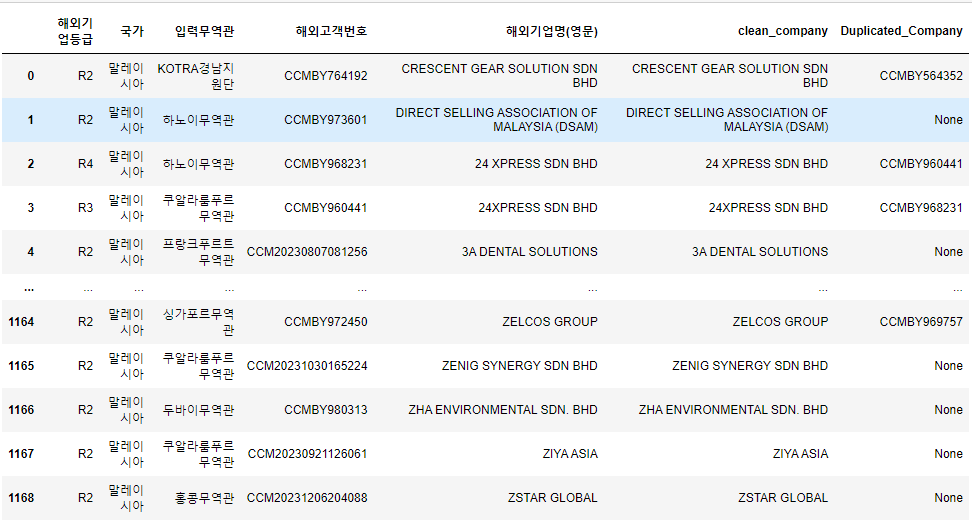

#### 새 코드

In [51]:
말레이시아_df

,해외기업등급,국가,입력무역관,해외고객번호,해외기업명(영문),clean_company,Duplicate_Company_Ids
100,R2,말레이시아,KOTRA경남지원단,CCMBY764192,CRESCENT GEAR SOLUTION SDN BHD,CRESCENT GEAR SOLUTION SDN BHD,[CCMBY564352]
105,R2,말레이시아,하노이무역관,CCMBY973601,DIRECT SELLING ASSOCIATION OF MALAYSIA (DSAM),DIRECT SELLING ASSOCIATION OF MALAYSIA (DSAM),None
537,R4,말레이시아,하노이무역관,CCMBY968231,24 XPRESS SDN BHD,24 XPRESS SDN BHD,[CCMBY960441]
542,R3,말레이시아,쿠알라룸푸르무역관,CCMBY960441,24XPRESS SDN BHD,24XPRESS SDN BHD,[CCMBY968231]
599,R2,말레이시아,프랑크푸르트무역관,CCM20230807081256,3A DENTAL SOLUTIONS,3A DENTAL SOLUTIONS,None
...,...,...,...,...,...,...,...
69131,R2,말레이시아,싱가포르무역관,CCMBY972450,ZELCOS GROUP,ZELCOS GROUP,[CCMBY969757]
69152,R2,말레이시아,쿠알라룸푸르무역관,CCM20231030165224,ZENIG SYNERGY SDN BHD,ZENIG SYNERGY SDN BHD,None
69248,R2,말레이시아,두바이무역관,CCMBY980313,ZHA ENVIRONMENTAL SDN. BHD,ZHA ENVIRONMENTAL SDN. BHD,None
69565,R2,말레이시아,쿠알라룸푸르무역관,CCM20230921126061,ZIYA ASIA,ZIYA ASIA,None


In [52]:
final_df=pd.concat([globals()[f'{country}_df'] for country in country_list], axis=0)
final_df.sort_values(by=['국가', '입력무역관'], inplace=True)
final_df.reset_index(drop=True, inplace=True)

In [57]:
len(final_df[(final_df['국가']=='말레이시아') &(final_df['Duplicate_Company_Ids']!='None')])

130

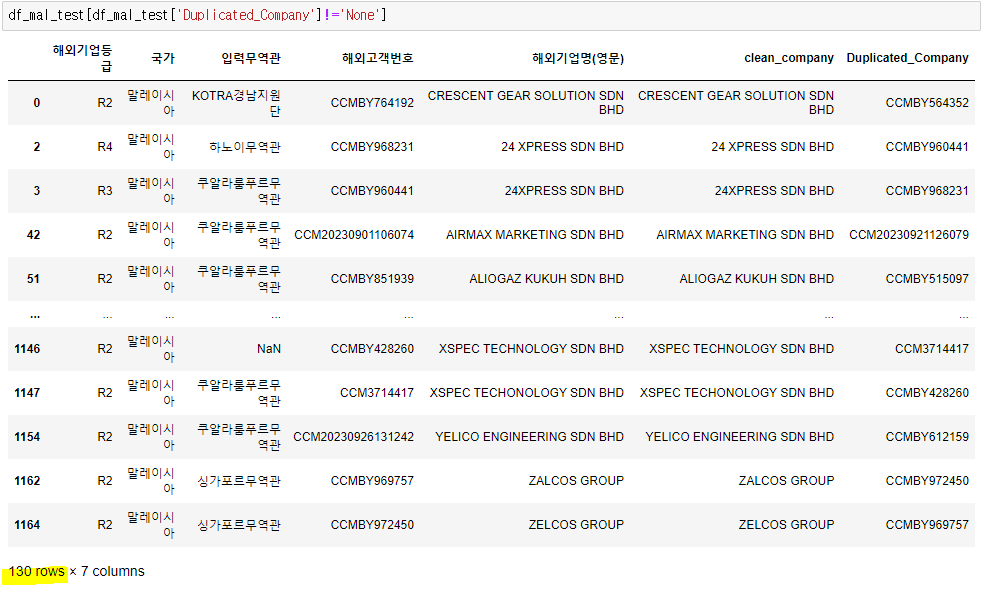

In [ ]:
#### For Study ####

In [5]:
company_dict = {}

company_dict.setdefault("ABC Corp", []).append(123)
print(company_dict)

{'ABC Corp': [123]}


In [7]:
company_dict.setdefault("abc", []).append(456)

In [8]:
company_dict

{'ABC Corp': [123], 'abc': [456]}

In [9]:
company_dict.setdefault("abc", []).append(789)

In [10]:
print(company_dict)

{'ABC Corp': [123], 'abc': [456, 789]}
